In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
base_metadata_pth = Path('/home/tsakalis/ntua/nestor_celvia/metadata')

basic_metadata_file = 'metadata.repository.2024-11-05.json'
clinical_cohort_file = 'clinical.cohort.2024-11-07.json'
biospecimen_file = 'biospecimen.cohort.2024-11-07.json'
gene_expr_file = 'Human__TCGA_OV__UNC__RNAseq__GA_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct'
# gene_expr_file = "Human__TCGA_OV__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct"

gene_mutation_file = 'Human__TCGA_OV__WUSM__Mutation__GAIIx__01_28_2016__BI__Gene__Firehose_MutSig2CV.cbt'

In [5]:
gene_names = pd.read_csv(base_metadata_pth / 'GeneNames.tsv', header=None)

In [6]:
metadata_df = pd.read_json(base_metadata_pth / basic_metadata_file)

clinical_cohort_df = pd.read_json(base_metadata_pth / clinical_cohort_file)

biospecimen_df = pd.read_json(base_metadata_pth / biospecimen_file)
gene_expr_df = pd.read_csv(base_metadata_pth / gene_expr_file, delimiter='\t')

gene_mutation_df = pd.read_csv(base_metadata_pth / gene_mutation_file,
                               delimiter='\t')

In [7]:
latent_vec_pth = Path(
    '/home/tsakalis/ntua/nestor_celvia/vae_embeddings/embeddings_adco')

In [8]:
import torch

In [9]:
import h5py
import pandas as pd


def load_h5(path, key='mean'):
    """
    Load data from an HDF5 file and return the specified dataset as a DataFrame.

    Parameters:
    - path (str): Path to the HDF5 file.
    - key (str): Key of the dataset to retrieve.

    Returns:
    - pd.DataFrame: DataFrame containing the data from the specified key.
    """
    with h5py.File(path, "r") as f:
        if key not in f:
            raise KeyError(f"Key '{key}' not found in the HDF5 file.")

        ds_arr = f[key][()]  # Get the numpy array from the specified key

    # Return the data as a DataFrame
    return pd.DataFrame(ds_arr)


In [10]:
latent_vec_pth = Path(
    '/home/tsakalis/ntua/nestor_celvia/vae_embeddings/embeddings_adco'
)
latent_vecs = [(pth.stem, load_h5(pth), load_h5(pth, key='max'),
                load_h5(pth, key='min'), load_h5(pth, key='std'))
               for pth in latent_vec_pth.glob('*.h5')]

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [11]:

latent_vec_pth = Path('/home/tsakalis/ntua/nestor_celvia/vae_embeddings/embeddings_adco_sampled')

latent_vecs = [(pth.stem,  pd.read_csv(pth))
               for pth in latent_vec_pth.glob('*.csv')]


In [12]:
# latent_vec_pth = Path(
#     '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/embeddings_adco'
# )
# latent_vecs = [(pth.stem, torch.load(pth,
#                                      map_location=torch.device('cpu')).numpy())
#                for pth in latent_vec_pth.glob('*.pt')]

# # latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [13]:
test_id = "TCGA-WR-A838-01A-01-TS1.E8CA96CD-A253-4090-86BA-60E7192B72FD"

In [14]:
all_latent_df = []
for latent in latent_vecs:
    latent_df = latent[1].copy()
    fname = latent[0]

    latent_df.columns = [f"emb_{i}" for i in range(1024)]

    latent_df['file_name'] = fname+ ".svs" 
    all_latent_df.append(latent_df)

In [15]:
# all_latent_df = []

# for latent in latent_vecs:
#     latent_df_mean = pd.DataFrame(latent[1]).transpose()
#     latent_df_max = pd.DataFrame(latent[2]).transpose()

#     latent_df_min = pd.DataFrame(latent[3]).transpose()
#     latent_df_std = pd.DataFrame(latent[4]).transpose()
#     latent_df = pd.concat(
#         [latent_df_mean, latent_df_max, latent_df_min, latent_df_std], axis=1)
#     # break
#     latent_df.columns = [f"emb_{i}" for i in range(4096)]
#     latent_df['file_name'] = latent[0] + ".svs"  #.split('_')[0]
#     if test_id == latent[0]:
#         break
#     all_latent_df.append(latent_df)

In [16]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/latent_vectors'
)

latent_vecs2 = [(pth.stem, np.load(pth))
                for pth in latent_vec_pth.glob('*.npy')]
                

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [17]:
metadata_df['submitter_id'] = metadata_df.submitter_id.apply(
    lambda x: '.'.join(x.split('-')[:3]))

In [18]:
merged_genes = pd.merge(gene_expr_df.set_index('attrib_name'),
                        gene_names,
                        left_index=True,
                        right_on=0)


In [19]:
clinical_cohort_df['submitter_id'] = clinical_cohort_df['submitter_id'].apply(
    lambda x: x.replace('-', '.'))

In [20]:
gene_patient = pd.merge(metadata_df,
                        merged_genes.T,
                        left_on='submitter_id',
                        right_index=True)

In [21]:
metadata_latent = pd.merge(metadata_df,
                           pd.concat(all_latent_df),
                           on='file_name')

In [22]:
all_data = pd.merge(metadata_latent,
                    gene_patient.reset_index(drop=True),
                    on='file_id',
                    how='inner')

In [23]:
all_data['md5sum_x']

0         05da084e2d65c34aa87bf865483f8b6d
1         05da084e2d65c34aa87bf865483f8b6d
2         05da084e2d65c34aa87bf865483f8b6d
3         05da084e2d65c34aa87bf865483f8b6d
4         05da084e2d65c34aa87bf865483f8b6d
                        ...               
399478    599802ce9923acaefba5524bad7c5139
399479    599802ce9923acaefba5524bad7c5139
399480    599802ce9923acaefba5524bad7c5139
399481    599802ce9923acaefba5524bad7c5139
399482    599802ce9923acaefba5524bad7c5139
Name: md5sum_x, Length: 399483, dtype: object

In [52]:
# Get unique values of the stratify column
from sklearn.model_selection import train_test_split

unique_values = all_data['file_id'].unique()

# Split unique values into train and test
train_ids, test_ids = train_test_split(unique_values,
                                       test_size=0.2,
                                       random_state=42)

In [53]:
train_ids

array(['db7b9c91-08be-4af8-be86-3dae153eb29d',
       'ffea0670-cc16-4753-aace-a2fecf71fd56',
       '6969b1be-b1fa-4c37-8872-dcbb84e6856c', ...,
       '6e1f77f7-db6d-4fab-99a3-6daa94f7fa7b',
       '4d3fc78c-5d40-4ebc-8990-d6ee8ec6aa1f',
       '45e8e8cc-3b48-45bf-ac6f-ecbee7dd2d0d'], dtype=object)

In [54]:
from sklearn.preprocessing import LabelEncoder

all_data['encoded'] = LabelEncoder().fit_transform(all_data['file_id'])
# all_data

In [55]:
train_data = all_data[all_data['file_id'].isin(train_ids)]

test_data = all_data[all_data['file_id'].isin(test_ids)]

In [56]:
test_data.shape

(80100, 1085)

In [117]:
are_identical = train_data.drop_duplicates('file_id')['file_id'].isin(test_data.drop_duplicates('file_id')['file_id'])


In [118]:
are_identical.sum()

0

In [59]:
target_labels = all_data.columns[-36:-1]

In [60]:
genes_ovarian_cancer = [
    "BRCA1", "BRCA2", "TP53", "RAD51C", "RAD51D", "PALB2", "ATM", "CHEK2",
    "PTEN", "ARID1A"
]


In [145]:
input_labels = [f"emb_{i}" for i in range(1024)] 

In [146]:
target_labels

Index([ 43,  86,  28, 101,  67,   2,  75,  70,  40,  59,  69,  90,  32,  98,
        89,  93,  95, 104,  97,  15, 116, 113,  14,  48,  37, 117,  34,   8,
       114,  71,  62, 110,  27,   4,  20],
      dtype='object')

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, classification_report, r2_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [148]:
target_labels

Index([ 43,  86,  28, 101,  67,   2,  75,  70,  40,  59,  69,  90,  32,  98,
        89,  93,  95, 104,  97,  15, 116, 113,  14,  48,  37, 117,  34,   8,
       114,  71,  62, 110,  27,   4,  20],
      dtype='object')

In [149]:
# train_data = all_data.loc[train_ids]
# test_data = all_data.loc[test_ids]

In [150]:
X_train, X_test, y_train, y_test = train_data[input_labels], test_data[
    input_labels], train_data[target_labels], test_data[target_labels]

In [151]:
params = {
    # 'n_estimators': 200,
    # 'min_samples_split': 10,
    # 'min_samples_leaf': 1,
    'max_features': 'sqrt',
    # 'max_depth': 10
}

In [75]:
# for i in range(len(target_labels)):
model = RandomForestRegressor(n_jobs=-1)  #n_estimators=100)
model.fit(X_train, y_train.values.astype(float))

# Make predictions
y_pred = model.predict(X_test)
# print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
print(r2_score(y_test.values.astype(float), y_pred)  )

0.004481470998375595


In [112]:
X_train.loc[(y_train[43]==6.8917)]

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_1015,emb_1016,emb_1017,emb_1018,emb_1019,emb_1020,emb_1021,emb_1022,emb_1023,encoded
145928,26.180069,0.220889,0.000000,9.993701,4.714709,7.362140,5.085289,11.345926,0.748165,6.173256,...,0.132060,22.709038,16.587280,19.878246,0.013346,13.872596,2.871491,11.026994,16.713268,124
145929,24.742603,0.200435,0.002628,9.110624,4.873423,7.371716,4.406344,11.353935,0.754496,6.220332,...,0.032054,21.257141,16.373040,19.117823,0.007599,12.737205,2.849313,10.418127,17.120789,124
145930,25.795140,0.234384,0.003789,9.951448,4.664169,7.506164,4.980003,11.782374,0.809662,6.745441,...,0.127152,22.743034,16.627304,20.068184,0.008365,13.494923,2.742984,11.040631,17.436588,124
145931,25.495125,0.211417,0.004887,9.314369,4.965889,7.146495,4.903326,11.411406,0.655503,6.296908,...,0.084845,21.955418,16.692295,19.712343,0.006469,13.174116,2.932083,10.581970,17.232552,124
145932,25.581253,0.225796,0.000000,9.377810,4.762380,7.138396,4.806961,11.593636,0.774952,6.184652,...,0.111792,22.126137,16.699970,19.933735,0.007867,13.178164,3.118279,10.969482,17.160313,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146223,25.001709,0.215974,0.001937,9.400592,4.742292,7.453806,4.749603,11.563495,0.837918,6.449849,...,0.129452,21.748432,16.573650,19.487120,0.008833,13.053215,2.767794,10.614889,17.040684,124
146224,22.945711,0.241006,0.004616,8.739695,4.240620,6.814197,4.603584,10.732735,0.896932,5.890409,...,0.108794,20.506044,15.090419,17.904160,0.015723,12.372572,2.623968,9.955898,15.338508,124
146225,23.103670,0.210494,0.002255,8.564510,4.350123,6.618957,4.527407,10.436241,0.595899,5.751564,...,0.088650,19.640854,15.280188,17.806480,0.000008,11.925601,2.782704,9.458235,15.534393,124
146226,23.183155,0.190706,0.003064,8.414480,4.379067,6.527020,4.764158,10.297223,0.671150,5.891885,...,0.106993,19.974829,15.020350,18.036388,0.015865,12.060867,2.691703,9.576242,15.291817,124


In [156]:
from catboost import CatBoostRegressor, Pool
catboost_params = {
    'learning_rate': 0.02630211356708753,
#  'n_estimators': 1504, 
 'depth': 4,
  'l2_leaf_reg': 0.07716793735981385, 
  'random_strength': 0.06958526592360514,
   'bagging_temperature': 0.27240920717632877
   }

In [161]:
cb_reg = CatBoostRegressor(
    objective='MultiRMSE',
    verbose=10,
    #  num_boost_round=100,
    **catboost_params
    # learning_rate=0.1,
    # n_estimators=10,
    #    num_boost_round=10
)
cb_reg.fit(X_train.values, y_train)
cb_pred2 = cb_reg.predict(X_test.values)
print(r2_score(y_test, cb_pred2))
# pd.DataFrame(cb_pred, columns=['Y1', 'Y2'])

0:	learn: 3.4632307	total: 1.04s	remaining: 1m 43s
10:	learn: 3.4536451	total: 10.5s	remaining: 1m 25s
20:	learn: 3.4469284	total: 20s	remaining: 1m 15s
30:	learn: 3.4420321	total: 29s	remaining: 1m 4s
40:	learn: 3.4382853	total: 38.2s	remaining: 54.9s
50:	learn: 3.4353259	total: 46.2s	remaining: 44.3s
60:	learn: 3.4327416	total: 54.9s	remaining: 35.1s
70:	learn: 3.4305586	total: 1m 3s	remaining: 26.1s
80:	learn: 3.4286385	total: 1m 13s	remaining: 17.3s
90:	learn: 3.4269761	total: 1m 22s	remaining: 8.16s
99:	learn: 3.4256062	total: 1m 29s	remaining: 0us
0.01083071526870549


In [162]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score, mean_squared_error
# import numpy as np

# # Define parameter grid for RandomForestRegressor
# param_grid = {
#     'n_estimators': [100, 150, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Initialize the RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # RandomizedSearchCV for lightweight optimization
# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_grid,
#     n_iter=20,  # Number of parameter settings to sample
#     cv=3,  # Number of folds for cross-validation
#     scoring='r2',
#     verbose=1,
#     random_state=42,
#     n_jobs=-1)

# # Fit the random search to the data
# random_search.fit(X_train, y_train.values)  # Flatten y_train for regression

# # Best parameters and evaluation
# best_model = random_search.best_estimator_
# print(f"Best Parameters: {random_search.best_params_}")

# # Evaluate the best model
# y_pred = best_model.predict(X_test)
# print(f"R2 Score: {r2_score(y_test, y_pred)}")
# print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")


In [163]:
# import lightgbm as lgb
# from sklearn.metrics import r2_score
# import numpy as np

# correls = []
# # Assuming y_train and y_test are numpy arrays with shape (n_samples, n_targets)
# for i in range(y_train.shape[1]):  # Loop over each target variable
#     # Prepare the LightGBM dataset
#     train_data = lgb.Dataset(X_train, label=y_train.values[:, i])
#     test_data = lgb.Dataset(X_test,
#                             label=y_test.values[:, i],
#                             reference=train_data)

#     # Set parameters
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'n_jobs': -1,
#         'verbosity': -1,
#         # 'num_leaves': 500,  # Large number of leaves to increase complexity
#         # 'max_depth': -1,  # No depth limit
#         # 'min_data_in_leaf': 1,  # Allow very small leaves
#         # 'min_child_samples': 1,  # Reduce the minimum data per child
#         # 'lambda_l1': 0,  # No L1 regularization
#         # 'lambda_l2': 0,  # No L2 regularization
#         # 'learning_rate': 0.1,  # Larger learning rate for faster overfitting
#         # 'feature_fraction': 1.0,  # Use all features
#         # 'bagging_fraction': 1.0,  # Use all data
#         # 'bagging_freq': 0,  # No bagging
#     }

#     # Train the model
#     model = lgb.train(
#         params,
#         train_data,
#         num_boost_round=100,
#         valid_sets=[train_data, test_data],
#         valid_names=['train', 'valid'],
#         #   early_stopping_rounds=10,
#         # verbose_eval=False
#     )

#     # Make predictions
#     y_pred = model.predict(X_test)

#     # Evaluate the model
#     r2 = r2_score(y_test.values[:, i], y_pred)
#     print(f"R2 score for target {i}: {r2}")
#     print(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten()))

#     correls.append(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten()))


In [164]:
y_test

,43,86,28,101,67,2,75,70,40,59,...,117,34,8,114,71,62,110,27,4,20
6900,6.8917,4.9819,8.3105,7.5195,8.0056,6.1413,7.5476,6.3456,7.4366,8.3753,...,9.0258,6.0745,7.9093,8.9901,9.0772,6.4052,8.9667,6.5934,7.3979,6.6269
6901,6.8917,4.9819,8.3105,7.5195,8.0056,6.1413,7.5476,6.3456,7.4366,8.3753,...,9.0258,6.0745,7.9093,8.9901,9.0772,6.4052,8.9667,6.5934,7.3979,6.6269
6902,6.8917,4.9819,8.3105,7.5195,8.0056,6.1413,7.5476,6.3456,7.4366,8.3753,...,9.0258,6.0745,7.9093,8.9901,9.0772,6.4052,8.9667,6.5934,7.3979,6.6269
6903,6.8917,4.9819,8.3105,7.5195,8.0056,6.1413,7.5476,6.3456,7.4366,8.3753,...,9.0258,6.0745,7.9093,8.9901,9.0772,6.4052,8.9667,6.5934,7.3979,6.6269
6904,6.8917,4.9819,8.3105,7.5195,8.0056,6.1413,7.5476,6.3456,7.4366,8.3753,...,9.0258,6.0745,7.9093,8.9901,9.0772,6.4052,8.9667,6.5934,7.3979,6.6269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399478,7.4709,5.5516,8.3982,7.8367,8.4115,7.3404,8.7977,7.6047,7.951,8.3318,...,8.7331,5.8354,8.0515,9.6339,7.6517,6.7537,8.526,5.095,8.211,6.5788
399479,7.4709,5.5516,8.3982,7.8367,8.4115,7.3404,8.7977,7.6047,7.951,8.3318,...,8.7331,5.8354,8.0515,9.6339,7.6517,6.7537,8.526,5.095,8.211,6.5788
399480,7.4709,5.5516,8.3982,7.8367,8.4115,7.3404,8.7977,7.6047,7.951,8.3318,...,8.7331,5.8354,8.0515,9.6339,7.6517,6.7537,8.526,5.095,8.211,6.5788
399481,7.4709,5.5516,8.3982,7.8367,8.4115,7.3404,8.7977,7.6047,7.951,8.3318,...,8.7331,5.8354,8.0515,9.6339,7.6517,6.7537,8.526,5.095,8.211,6.5788


In [166]:
final_labels = []
final_preds = []
for aggr  in y_test.reset_index(drop=True).groupby([43,86]).apply(lambda x: x.index).tolist():
    true_lbl = y_test.iloc[aggr,:].iloc[0].values.flatten()

    mean_pred = cb_pred2[aggr,:].mean(axis=0)
    final_labels.append(true_lbl)
    final_preds.append(mean_pred)
    

/tmp/ipykernel_305264/3367327688.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  for aggr  in y_test.reset_index(drop=True).groupby([43,86]).apply(lambda x: x.index).tolist():


In [122]:
final_labels = []
final_preds = []
for aggr  in X_test.reset_index(drop=True).groupby('encoded').apply(lambda x: x.index).tolist():
    true_lbl = y_test.iloc[aggr,:].iloc[0].values.flatten()

    mean_pred = y_pred[aggr, :].mean(axis=0)
    final_labels.append(true_lbl)
    final_preds.append(mean_pred)
    

array([7.1757, 5.79, 7.5534, 6.0288, 7.7661, 8.0182, 7.8204, 4.8732,
       6.9005, 8.3245, 8.0928, 7.8061, 8.5346, 8.4498, 6.3679, 9.1646,
       8.2125, 7.8604, 5.7166, 7.4328, 6.8112, 7.4804, 7.2173, 9.0975,
       9.38, 9.0369, 5.9333, 8.321, 9.3635, 9.5174, 5.9692, 7.7409,
       8.4282, 7.6551, 7.8563], dtype=object)

In [167]:
mean_pred

array([7.13184887, 5.11677456, 7.98805042, 6.92283697, 7.76362939,
       6.86805252, 8.08687325, 7.3952236 , 7.72707894, 8.5069588 ,
       7.25995618, 8.51542005, 8.39160439, 8.17873732, 6.87877819,
       9.13332485, 8.03420487, 8.08432818, 6.1579365 , 7.84596953,
       6.819671  , 7.55952027, 7.19518375, 8.67961715, 9.48546696,
       9.00624099, 5.96442904, 7.94977095, 9.25944806, 8.54552118,
       6.68880167, 8.36041701, 6.46788936, 7.84768578, 7.08968083])

In [170]:
r2_score(np.stack(final_labels),np.stack(final_preds))

0.018052570691938323

In [171]:
from scipy import stats
correls = []
for i in range(len(target_labels)):
    correls.append(
        stats.spearmanr(np.stack(final_labels)[:, i].flatten().astype(float),
                        np.stack(final_preds)[:, i].flatten()).statistic)

In [172]:
np.stack(final_labels).shape

(229, 35)

In [173]:
corrlesb = []
for i in range(len(target_labels)):
    corrlesb.append(
        stats.spearmanr(y_test.values[:, i].flatten().astype(float),
                        y_pred[:, i].flatten()))

In [174]:
correls = []
for i in range(len(target_labels)):
    correls.append(
        np.corrcoef(y_test.values[:, i].flatten().astype(float),
                    y_pred[:, i].flatten())[0, 1])


    # plt.scatter(y_test.values[:, i].flatten().astype(float), y_pred[:, i].flatten())
    

In [175]:
sorted(correls)[::-1]

[0.32276974054496005,
 0.2985183556979867,
 0.24392034491662445,
 0.23591443177536522,
 0.23498911727933167,
 0.22398720453904633,
 0.21868946251539145,
 0.20640192859648313,
 0.2034264608548269,
 0.1935834292010516,
 0.14995647361493086,
 0.13684116092676313,
 0.1313444497683255,
 0.12585665554708908,
 0.12209245025231018,
 0.11679853814526263,
 0.10144900270720353,
 0.09901416237823309,
 0.09811003350930055,
 0.08627898332217165,
 0.08570129866425809,
 0.07580108970274883,
 0.07306249735854711,
 0.07174176279432504,
 0.0715962832343796,
 0.07073612792474719,
 0.06742594512478889,
 0.05859475811533238,
 0.04844227303686459,
 0.04177162341554563,
 0.014356549259008375,
 0.003107105614805087,
 0.001043757222117596,
 -0.004698625629684702,
 -0.018222008478179435]

In [91]:
# for i in range(len(target_labels)):
#     model = RandomForestRegressor()
#     model.fit(X_train, y_train.values[:, i])

#     # Make predictions
#     y_pred = model.predict(X_test)
#     # print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
#     print(r2_score(y_test.values[:, i], y_pred))
#     print(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten())[0, 1])

In [92]:
y_test.shape

(80100, 35)

In [93]:
def find_vector_duplicates(array1, array2):
    # Convert each vector to a tuple for hashable comparison
    set1 = {tuple(vec) for vec in array1}
    duplicates = [vec for vec in array2 if tuple(vec) in set1]
    return duplicates

In [94]:
correls

[0.23591443177536522,
 0.14995647361493086,
 0.24392034491662445,
 0.04177162341554563,
 0.06742594512478889,
 0.07306249735854711,
 0.23498911727933167,
 0.014356549259008375,
 0.10144900270720353,
 0.2985183556979867,
 0.05859475811533238,
 0.2034264608548269,
 0.21868946251539145,
 0.003107105614805087,
 0.0715962832343796,
 0.07580108970274883,
 0.32276974054496005,
 0.1935834292010516,
 -0.018222008478179435,
 0.001043757222117596,
 0.04844227303686459,
 0.09811003350930055,
 0.12209245025231018,
 0.1313444497683255,
 0.08570129866425809,
 0.12585665554708908,
 0.07073612792474719,
 0.07174176279432504,
 0.09901416237823309,
 -0.004698625629684702,
 0.22398720453904633,
 0.20640192859648313,
 0.11679853814526263,
 0.08627898332217165,
 0.13684116092676313]

In [95]:
correls

[0.23591443177536522,
 0.14995647361493086,
 0.24392034491662445,
 0.04177162341554563,
 0.06742594512478889,
 0.07306249735854711,
 0.23498911727933167,
 0.014356549259008375,
 0.10144900270720353,
 0.2985183556979867,
 0.05859475811533238,
 0.2034264608548269,
 0.21868946251539145,
 0.003107105614805087,
 0.0715962832343796,
 0.07580108970274883,
 0.32276974054496005,
 0.1935834292010516,
 -0.018222008478179435,
 0.001043757222117596,
 0.04844227303686459,
 0.09811003350930055,
 0.12209245025231018,
 0.1313444497683255,
 0.08570129866425809,
 0.12585665554708908,
 0.07073612792474719,
 0.07174176279432504,
 0.09901416237823309,
 -0.004698625629684702,
 0.22398720453904633,
 0.20640192859648313,
 0.11679853814526263,
 0.08627898332217165,
 0.13684116092676313]

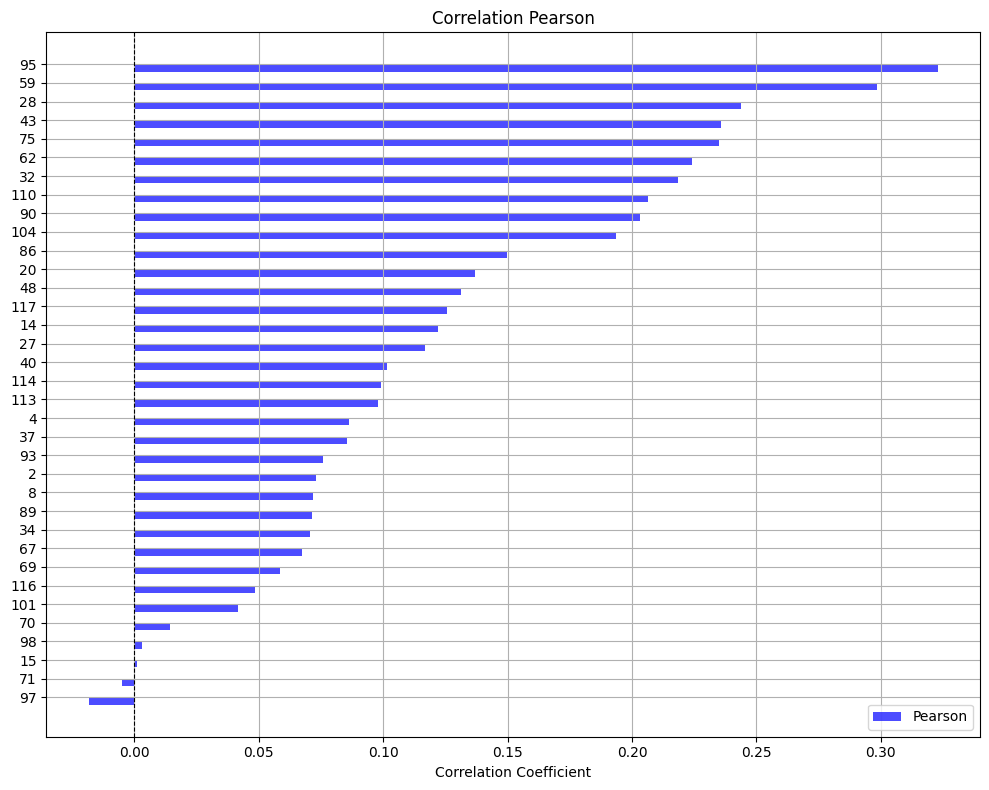

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the plot (example data, replace with actual values)
sort_idx = np.argsort(correls)#[::-1]
genes = np.array(target_labels)[sort_idx[:35]]

# Plotting
y_pos = np.arange(len(genes))

plt.figure(figsize=(10, 8))
plt.barh(y_pos - 0.2,
         np.array(correls)[sort_idx[:35]],
         height=0.4,
         label='Pearson',
         color='blue',
         alpha=0.7)
# plt.barh(y_pos + 0.2, spearman, height=0.4, label='Spearman', color='orange', alpha=0.7)

plt.yticks(y_pos, genes)
plt.xlabel("Correlation Coefficient")
plt.title("Correlation Pearson")
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()


In [ ]:
y_test.shape

In [ ]:
np.corrcoef(y_test.T, y_pred.T)

In [ ]:
pca_vecs = pca.fit_transform(latent_vecs)

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
pca.get_covariance()

In [ ]:
np.corrcoef(pca_vecs[:, 0], [pca_vecs[:, 1]])

In [ ]:
plt.scatter(pca_vecs[:, 0], [pca_vecs[:, 1]])
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)